# imports

In [1]:
import tensorflow as tf 
from tensorflow import keras 
import sklearn
from sklearn.metrics import roc_curve, auc, log_loss, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib as mplb 
import matplotlib.pyplot as plt 
#plt.style.use('ggplot')
import numpy as np
import pandas as pd 

import seaborn as sns

import os 
import zipfile
import shutil
import getpass
import requests
from IPython.display import clear_output
from tqdm.notebook import tqdm

# Config

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_val = 2020

# set seed 
np.random.seed(seed=seed_val)

tf.random.set_seed(seed=seed_val)

# Params

In [3]:
IMG_SIZE = 300
IMG_SHAPE  = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32
class_names = ['NEG', 'POS']
base_dir = '../'
train_images_dir = os.path.join(base_dir, 'Datasets/Images', 'train')
val_images_dir = os.path.join(base_dir, 'Datasets/Images', 'val')
test_images_dir = os.path.join(base_dir, 'Datasets/Images', 'test')

train_csv_path = os.path.join(base_dir, 'Datasets/Csv', 'Train.csv')
test_csv_path = os.path.join(base_dir, 'Datasets/Csv', 'Test.csv')
sample_csv_path = os.path.join(base_dir, 'Datasets/Csv', 'Train.csv')

In [4]:
train_df  = pd.read_csv(train_csv_path)
test_df  = pd.read_csv(test_csv_path)
sample_sub_df = pd.read_csv(sample_csv_path)

In [5]:
train_df.head()

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0
2,train/PMRSQLXN.png,PMRSQLXN,0
3,train/JXISWDUU.png,JXISWDUU,1
4,train/JVWMAACC.png,JVWMAACC,1


In [6]:
test_df.head()

,filename,ID
0,test/GTWSHFYQ.png,GTWSHFYQ
1,test/QTFSSMGD.png,QTFSSMGD
2,test/TBLBHSYT.png,TBLBHSYT
3,test/ZKETEOFG.png,ZKETEOFG
4,test/GKTPBGZP.png,GKTPBGZP


In [7]:
sample_sub_df.tail()

,filename,ID,LABEL
713,train/EWGJDECH.png,EWGJDECH,1
714,train/CJEVKQUT.png,CJEVKQUT,1
715,train/YDXXBDGI.png,YDXXBDGI,1
716,train/QLUOORWZ.png,QLUOORWZ,0
717,train/HFAGCLGV.png,HFAGCLGV,1


# Datasets & Dataloaders

In [8]:
image_generator = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                                                                rotation_range=25,
                                                                width_shift_range=0.1,
                                                                zoom_range=0.1,
                                                                fill_mode='nearest',
                                                                horizontal_flip=True,
                                                                #vertical_flip=True,
                                                                rescale=None,
                                                                validation_split=0.15)


In [9]:
train_generator = image_generator.flow_from_directory(directory=train_images_dir+'/train', 
                                                      target_size=(IMG_SIZE, IMG_SIZE), 
                                                      batch_size=BATCH_SIZE, 
                                                      seed=seed_val, 
                                                      subset='training')

validation_generator = image_generator.flow_from_directory(directory=train_images_dir+'/train', 
                                                      target_size=(IMG_SIZE, IMG_SIZE), 
                                                      batch_size=BATCH_SIZE, 
                                                      seed=seed_val, 
                                                      subset='validation')

Found 612 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [34]:
for imgs, labels in train_generator:
    print(imgs.shape, labels[0])
    break

(16, 416, 416, 3) [1. 0.]


In [11]:
# traditional image loading 
def get_train_images_and_labels():
    train_images_list = []
    train_labels_list = []

    for folder in os.listdir(os.path.join(train_images_dir, 'train')):
        try:
            for img in tqdm(os.listdir(os.path.join(train_images_dir, 'train', folder)), desc=f"Now on folder {folder}"):
                x = keras.preprocessing.image.load_img(path=os.path.join(train_images_dir, 'train', folder, img), 
                                                       target_size=(IMG_SIZE, IMG_SIZE))

                x = keras.preprocessing.image.img_to_array(x)
                train_images_list.append(x)
                if folder == "TB-0":
                    label = np.eye(2)[0]
                else:
                    label = np.eye(2)[1]

                train_labels_list.append(label)
        except:
            pass
        
    return np.array(train_images_list), np.array(train_labels_list)



train_images_list, train_labels_list = get_train_images_and_labels()

In [12]:
len(train_images_list), len(train_labels_list)

(718, 718)

# Visualization

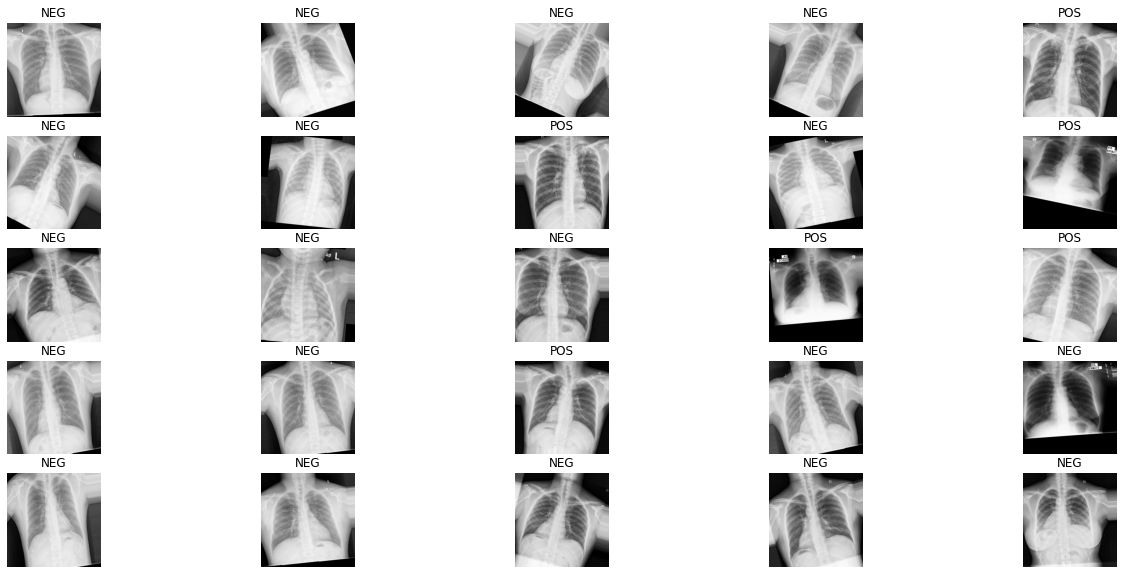

In [13]:
def show_training_sample(batch_size=BATCH_SIZE):
    imgs, labs = next(iter(train_generator))
    plt.figure(figsize=(22, 10))
    for i in range(min(25, batch_size)):
        l, c = 5, 5
        img = imgs[i] / 255.0
        label = class_names[tf.argmax(labs[i])]
        ax = plt.subplot(l, c, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
        
        
        
        
        
show_training_sample()

In [14]:
arch_name = "ResNet101"
base_arch = getattr(tf.keras.applications, arch_name) 
base_model = base_arch(include_top=False, input_shape=IMG_SHAPE)

In [16]:
# freeze trained layers
for layer in base_model.layers:
    layer.trainable = False


def build_model(fc_size=2, n_dense_units=512):
    
    inputs = inputs = keras.Input(shape=IMG_SHAPE)
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(units=n_dense_units, activation='relu')(x)
    x = keras.layers.Dropout(0.1)(x)
    
    if fc_size > 1:
        predictions = keras.layers.Dense(units=fc_size, activation="softmax")(x)
        
    else:
        predictions = keras.layers.Dense(units=1, activation="sigmoid")(x)
    
    model = keras.Model(inputs = inputs, outputs=predictions)
    
    return model

In [17]:
model = build_model(fc_size=2, n_dense_units=512)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
resnet101 (Model)            (None, 10, 10, 2048)      42658176  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 43,708,290
Trainable params: 1,050,114
Non-trainable params: 42,658,176
_________________________________________

# Training phase

# Report bot config 
access_token = getpass.getpass(prompt="Enter the API token from your Telegram bot here : ")

class botCallback(keras.callbacks.Callback):
    def __init__(self,access_token):
        self.access_token = access_token
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/getUpdates'
        self.response = requests.get(self.ping_url).json()
        self.chat_id = self.response['result'][0]['message']['chat']['id']

    def send_message(self,message):
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/sendMessage?'+\
                        'chat_id='+str(self.chat_id)+\
                        '&parse_mode=Markdown'+\
                        '&text='+message
        self.response = requests.get(self.ping_url)
    
    def send_photo(self,filepath):
        file_ = open(filepath,'rb')
        file_dict = {'photo':file_}
        self.ping_url = 'https://api.telegram.org/bot'+str(self.access_token)+'/sendPhoto?'+\
                    'chat_id='+str(self.chat_id)
        self.response = requests.post(self.ping_url,files = file_dict)
        file_.close()

    def on_train_batch_begin(self, batch, logs=None):
        #keys = list(logs.keys())
        #print("...Training: start of batch {}; got log keys: {}".format(batch, keys))
        pass
    
    def on_train_batch_end(self, batch, logs=None):
        #keys = list(logs.keys())
        #print("...Training: end of batch {}; got log keys: {}".format(batch, keys))
        #message = ' Iteration/Batch {}\n Training Accuracy : {:7.2f}\n Training Loss : {:7.2f}\n'.format(batch,logs['accuracy'],logs['loss'])
        #message += ' Validation Accuracy : {:7.2f}\n Validation Loss : {:7.2f}\n'.format(logs['val_accuracy'],logs['val_loss'])
        #self.send_message(message)
        pass

    def on_test_batch_begin(self, batch, logs=None):
        #keys = list(logs.keys())
        #print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))
        pass
    
    def on_test_batch_end(self, batch, logs=None):
        #message = ' Iteration/Batch {}\n Training Accuracy : {:7.2f}\n Training Loss : {:7.2f}\n'.format(batch,logs['accuracy'],logs['loss'])
        #message += ' Validation Accuracy : {:7.2f}\n Validation Loss : {:7.2f}\n'.format(logs['val_accuracy'],logs['val_loss'])
        #self.send_message(message)
        pass

    def on_epoch_begin(self, epoch, logs=None):
        message = f'Epoch {epoch+1} starts...\n'
        try:
            self.send_message(message)
        except:
            pass

    def on_epoch_end(self, epoch, logs=None):
        try:
            message = ' Epoch {} report\n Training Accuracy : {:7.2f}\n Training Loss : {:7.2f}\n'.format(epoch+1,logs['accuracy'],logs['loss'])
            message += ' Validation Accuracy : {:7.2f}\n Validation Loss : {:7.2f}\n'.format(logs['val_accuracy'],logs['val_loss'])
            self.send_message(message)
        except:
            pass


class Plotter(botCallback):
    def __init__(self,access_token):
        super().__init__(access_token)

    def on_train_begin(self,logs=None):
        self.batch = 0
        self.epoch = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.fig = plt.figure(figsize=(200,100))
        self.logs = []
    
    def on_epoch_end(self, epoch, logs=None):

        self.logs.append(logs)
        self.epoch.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['accuracy'])
        self.val_acc.append(logs['val_accuracy'])

        f,(ax1,ax2) = plt.subplots(1,2,sharex=True)

        clear_output(wait=True)

        ax1.plot(self.epoch, self.train_loss, label='Training Loss')
        ax1.plot(self.epoch, self.val_loss, label='Validation Loss')
        ax1.legend()

        ax2.plot(self.epoch, self.train_acc, label='Training Accuracy')
        ax2.plot(self.epoch, self.val_acc, label='Validation Accuracy')
        ax2.legend()
        img_path = os.path.join(base_dir, "Imgs")
        plt.savefig(os.path.join(img_path, 'Accuracy_and_Loss_plot.jpg'))
        plt.close(fig=f)
        try:
            self.send_photo(os.path.join(img_path, 'Accuracy_and_Loss_plot.jpg'))
        except:
            pass

In [18]:
# training params 
# optimizer
lr = 9.9e-4
optimizer = keras.optimizers.Adam(learning_rate=lr)

# loss 
loss_fn = keras.losses.BinaryCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

num_epochs = 30
optim_name = optimizer.get_config()['name']
model_name = f'tf_model_x_rays_based_on_{arch_name}_and_{optim_name}.h5'
model_path = os.path.join(base_dir, 'Models', model_name)

acc_ckpt = keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1, monitor='val_accuracy', save_best_only=True)
loss_ckpt = keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1, monitor='val_loss', save_best_only=True)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, 
                                   verbose=1, mode='max', min_lr=lr)

# bot config
#bot_callback = botCallback(access_token=access_token)
#plotter = Plotter(access_token)

CALLBACKS = [acc_ckpt, loss_ckpt, es, reduce_lr] #bot_callback, plotter]

In [19]:
h = model.fit(train_generator, 
              validation_data=validation_generator, 
              epochs=num_epochs, 
              steps_per_epoch=train_generator.n // BATCH_SIZE,
              validation_steps=validation_generator.n // BATCH_SIZE, 
              callbacks=CALLBACKS)

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 1.7117 - accuracy: 0.5793
Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to ../Models/tf_model_x_rays_based_on_ResNet101_and_Adam.h5

Epoch 00001: val_loss improved from inf to 0.56810, saving model to ../Models/tf_model_x_rays_based_on_ResNet101_and_Adam.h5
19/19 [==============================] - 82s 4s/step - loss: 1.7117 - accuracy: 0.5793 - val_loss: 0.5681 - val_accuracy: 0.6250 - lr: 9.9000e-04
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.5365 - accuracy: 0.7632
Epoch 00002: val_accuracy improved from 0.62500 to 0.80208, saving model to ../Models/tf_model_x_rays_based_on_ResNet101_and_Adam.h5

Epoch 00002: val_loss improved from 0.56810 to 0.44661, saving model to ../Models/tf_model_x_rays_based_on_ResNet101_and_Adam.h5
19/19 [==============================] - 78s 4s/step - loss: 0.5365 - accuracy: 0.7632 - val_loss: 0.4466 - val_accuracy: 0.8021 - lr: 9.9000e-04

KeyboardInterrupt: 

# cross validation



def run_cv(num_epochs=10, num_folds=10, batch_size=BATCH_SIZE):
    
    kf = KFold(n_splits=num_folds)
    
    cv_models_path = os.path.join(base_dir, 'Models', 'CV_models')
    histories = []

    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X=train_images_list, y=train_labels_list)):

        train_ds = image_generator.flow(x = train_images_list[train_idx], 
                                        y=train_labels_list[train_idx], 
                                        batch_size=batch_size, 
                                        seed=seed_val, 
                                        shuffle=True, 
                                        subset='training') 

        val_ds = image_generator.flow(x = train_images_list[val_idx], 
                                      y=train_labels_list[val_idx], 
                                        batch_size=batch_size, 
                                        seed=seed_val, 
                                        shuffle=False, 
                                        subset='validation')
        
        
        # training params 
        # optimizer
        lr = 9.9e-5
        optimizer = keras.optimizers.Nadam(learning_rate=lr)
        optim_name = optimizer.get_config()['name']
        # loss 
        loss_fn = keras.losses.BinaryCrossentropy()
        
        # model
        model = build_model(fc_size=2, n_dense_units=512)
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
        model_path = os.path.join(cv_models_path, f"tf_xrays_model_based_on_{arch_name}_and_{optim_name}_fold_{fold_num+1}.h5")
        
        acc_ckpt = keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1, monitor='val_accuracy', save_best_only=True)
        loss_ckpt = keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1, monitor='val_loss', save_best_only=True)
        es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
        def scheduler(epoch):
            if epoch % 10 == 0:
                return lr*0.01
            else:
                return lr

        lr_sch = keras.callbacks.LearningRateScheduler(scheduler)
        CALLBACKS = [acc_ckpt, loss_ckpt, es, lr_sch]
        
        print(f"\n[INFO] =========== Training on fold {fold_num + 1}/{num_folds} ===========\n")
        h = model.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=num_epochs,
                      steps_per_epoch=train_ds.n // batch_size,
                      validation_steps = val_ds.n // batch_size,
                      callbacks=CALLBACKS)

        histories.append(h)
        del train_ds
        del val_ds
        del model
        
    return histories, cv_models_path, optim_name, lr

num_epochs=40
num_folds=5

histories, cv_models_path, optim_name, lr = run_cv(num_epochs=num_epochs, num_folds=num_folds, batch_size=min(8, BATCH_SIZE))

# Results

try:
    for h in histories:
        plt.figure(figsize=(20,5))
        loss = h.history['loss']
        acc = h.history['accuracy']
        val_loss = h.history['val_loss']
        val_acc = h.history['val_accuracy']

        plt.subplot(1, 2, 1)
        plt.plot(loss, label='training loss')
        plt.plot(val_loss, label='validation loss')
        plt.title("Losses results", size=16)
        plt.xlabel("epoch")
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(acc, label='training acc')
        plt.plot(val_acc, label='validation acc')
        plt.title("Accuracies results", size=16)
        plt.xlabel("epoch")
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()
        
except:
    plt.figure(figsize=(20,6))
    loss = h.history['loss']
    acc = h.history['accuracy']
    val_loss = h.history['val_loss']
    val_acc = h.history['val_accuracy']

    plt.subplot(1, 2, 1)
    plt.plot(loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.title("Losses results", size=16)
    plt.xlabel("epoch")
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc, label='training acc')
    plt.plot(val_acc, label='validation acc')
    plt.title("Accuracies results", size=16)
    plt.xlabel("epoch")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# save/load model
model_name = f'tf_model_x_rays_based_on_{arch_name}.h5'
model_path = os.path.join(base_dir, 'Models', model_name)
model.save(model_path)

print(f'[INFO] Model {model_name} saved to {model_path}')

loaded_model = keras.models.load_model(model_path)
loaded_model.summary()

# Predictions

In [20]:
def load_models(cv_models_path = os.path.join(base_dir, 'Models', 'CV_models'), optim_name="Adam"):
    models = []
    n_folds = 5
    try:
        for fold_num in range(1, n_folds+1):
            m = keras.models.load_model(os.path.join(cv_models_path, f"tf_xrays_model_based_on_{arch_name}_and_{optim_name}_fold_{fold_num}.h5"))
            m.trainable = False
            models.append(m)
    except :
        model.trainable = False
        models.append(model)
        
    return models


models = load_models(optim_name=optim_name)
    
len(models)

1

In [22]:
def test_step(models):
    images_test = []
    predictions = []
    
    for im in tqdm(os.listdir(os.path.join(test_images_dir, 'test')), desc=f"Predicting on test images "):
        images_test.append(im.split('.')[0])
        x = keras.preprocessing.image.load_img(os.path.join(test_images_dir, 'test', im), target_size=(IMG_SIZE, IMG_SIZE))
        x = keras.preprocessing.image.img_to_array(x)
        
        tmp_preds = []
        for model in models: 
            pred = model.predict(x.reshape(-1, IMG_SIZE, IMG_SIZE, 3))[0][1]# get column 1 of prediction
            tmp_preds.append(pred)
        
        predictions.append(np.array(tmp_preds).mean())
                
    return images_test, predictions


images_test, predictions = test_step(models = models)

assert len(predictions) == len(images_test)

In [23]:
my_file = pd.DataFrame({
    'ID': images_test,
    'LABEL':predictions
})

my_file

,ID,LABEL
0,BPMOOTCZ,0.992457
1,CHDDLHBE,0.199309
2,OUDDWOML,0.069136
3,XZCNSJAC,0.976891
4,RIHEHUTM,0.039809
...,...,...
77,LWOMGDGX,0.444347
78,JUQVMIEU,0.484490
79,FTBBVMHK,0.997971
80,XFBRFQRL,0.038616


In [24]:
num_epochs = 36

In [25]:
if len(models) > 1:
    file_name = f'tf_xrays_based_on_{arch_name}_optimizer_{optim_name}_bs_{BATCH_SIZE}_ep_{num_epochs}_lr_{lr}_n_folds_{num_folds}.csv'
else:
    file_name = f'tf_xrays_based_on_{arch_name}_optimizer_{optim_name}_bs_{BATCH_SIZE}_ep_{num_epochs}_lr_{lr}.csv'
    
    
    
    
my_file.to_csv(os.path.join(base_dir, 'Submissions', file_name), index=False)

print(f"[INFO] Saved file as {file_name}")

[INFO] Saved file as tf_xrays_based_on_ResNet101_optimizer_Adam_bs_32_ep_36_lr_0.00099.csv



preds = my_file.LABEL.values
base_file = pd.read_csv(os.path.join(base_dir, 'Submissions', "tf_xrays_based_on_ResNet50_optimizer_Adam_bs_16_ep_150_lr_9.9e-05_best_one.csv"))

y_true = base_file.LABEL.values
for idx, val in enumerate(y_true):
    if val >.5:
        y_true[idx] = 1
    else:
        y_true[idx] = 0
